# RCFM Model

## 1. Import modules and helper functions

In [1]:
# Modules
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.optimize import curve_fit

# Helper functions from DataAid.py and DataImport.py
import DataAid
import DataImporter

# Numerically stable class of functions from Neros_v2.py
import Neros_v2

## 2. Load Galaxy Data

In [2]:
# Load Galaxy Data
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
littleDataGalaxies = DataAid.GetGalaxyData("data/little-data-things/data/")
lcmGalaxies = DataAid.GetGalaxyData("data/LCMFits/data/")

# Load Milky Way Model Data
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
mcGaughMW = DataAid.GetGalaxyData("data/McGaugh/")

# Create array of Milky Way radius and vlum tuples from model data
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])
MWMcGaugh = np.array(mcGaughMW['MW_lumMcGaugh'])


## 3. Create Neros class instance

In [3]:
# Create Neros instance to perform calculations with the supplied Milky Way model as comparison
# Change Milky Way model by changing the variable in the parentheses
# i.e. neros_fns = Neros_v2.Neros(MWModelVariable)

neros_fns = Neros_v2.Neros(MWXueSofue)
MW_name = "MWXueSofue" # Change this if you change the MW model in neros_fns!
MW_rad = neros_fns.mw_rad
MW_vLum = neros_fns.mw_vLum
MW_phi = neros_fns.mw_phi

MW_vLum_interp_func = neros_fns.mw_vLum_interp

## 4. Designate outfile name, initialize variables, and designate galaxy sample

In [5]:
# This designates which galaxy sample to fit
galaxies = lcmGalaxies


## 5. Fit galaxies, print and save graphs

galaxyName is: M31_Carignan_SNC
chi_squared is: 0.28115631062710617
alpha is: 10.204442192635963
disk_scale is: 0.9525918018742477
bulge_scale is: 0.7351240581324484
--------------------------
Running average chi_squared: 0.28115631062710617


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


galaxyName is: NGC925_TokyCarignan_Original
chi_squared is: 7.629352487194201
alpha is: 2.5701994706068027e-10
disk_scale is: 1.2622625962308114
bulge_scale is: 1.0
--------------------------
Running average chi_squared: 3.955254398910654
galaxyName is: N891_Fraternalli
chi_squared is: 0.65683574943148
alpha is: 3.122836542692424
disk_scale is: 0.9852010829086235
bulge_scale is: 0.897286264119378
--------------------------
Running average chi_squared: 2.855781515750929
galaxyName is: NGC7793_GentileTaM
chi_squared is: 30.115370847130023
alpha is: 1.8898978780284414e-13
disk_scale is: 1.6108082286704482
bulge_scale is: 1.0
--------------------------
Running average chi_squared: 9.670678848595703
galaxyName is: M31_Carignan_SNC2
chi_squared is: 0.2646425567442005
alpha is: 10.048462826522647
disk_scale is: 0.9457377833710299
bulge_scale is: 0.7513246632895016
--------------------------
Running average chi_squared: 7.789471590225402
galaxyName is: NGC2403_Botteman_LCM
chi_squared is: 155.

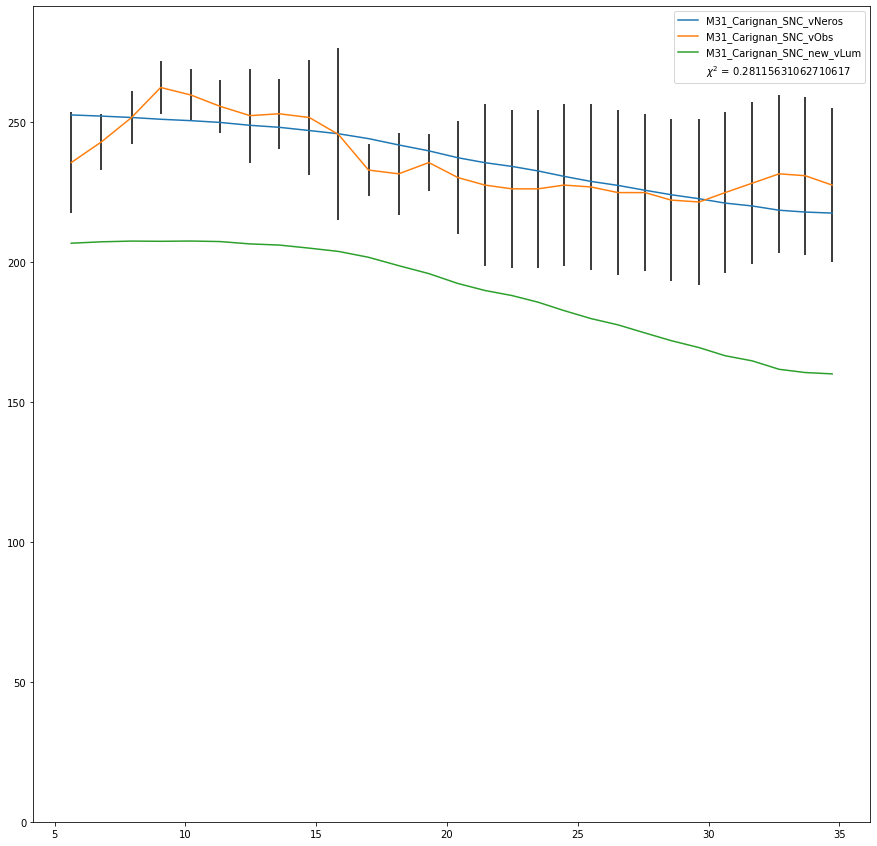

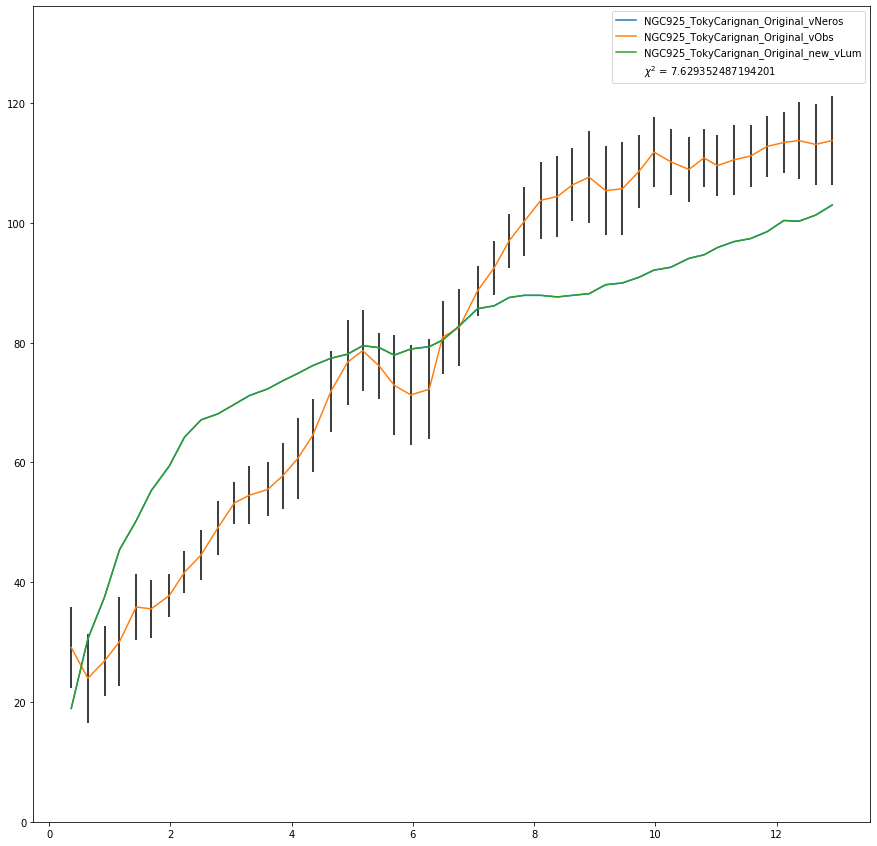

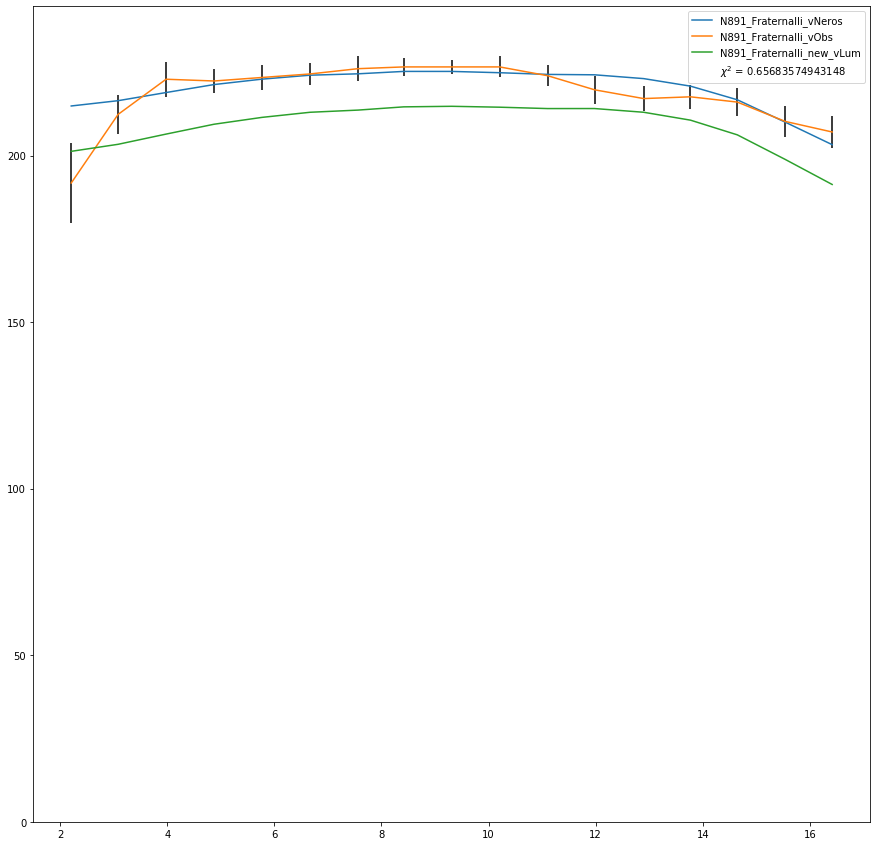

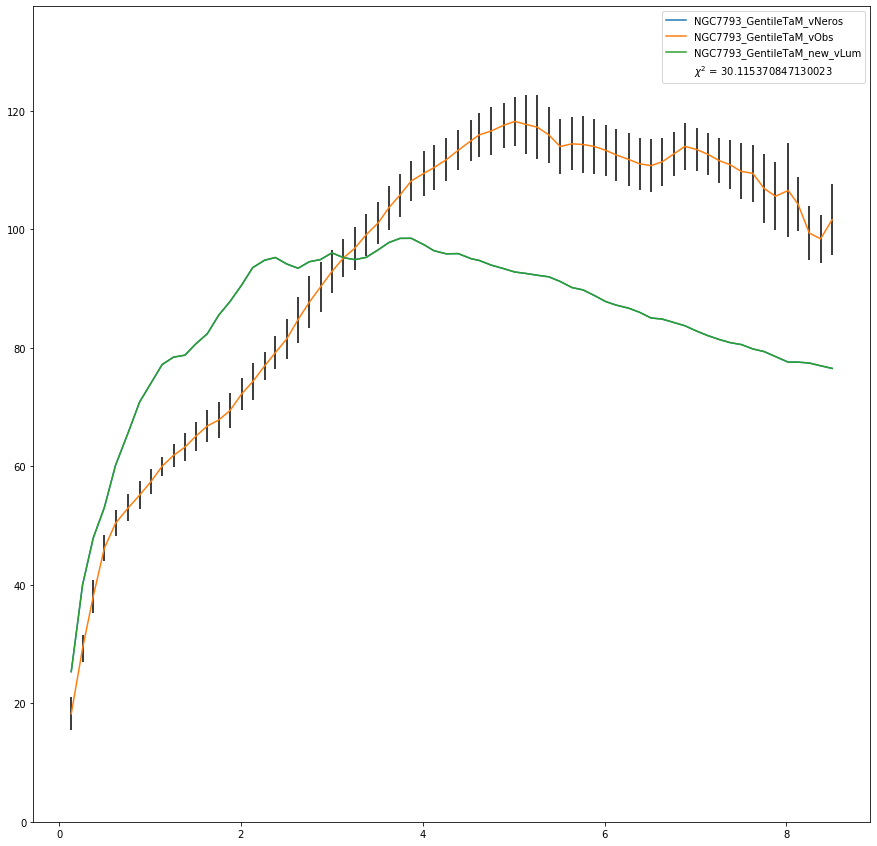

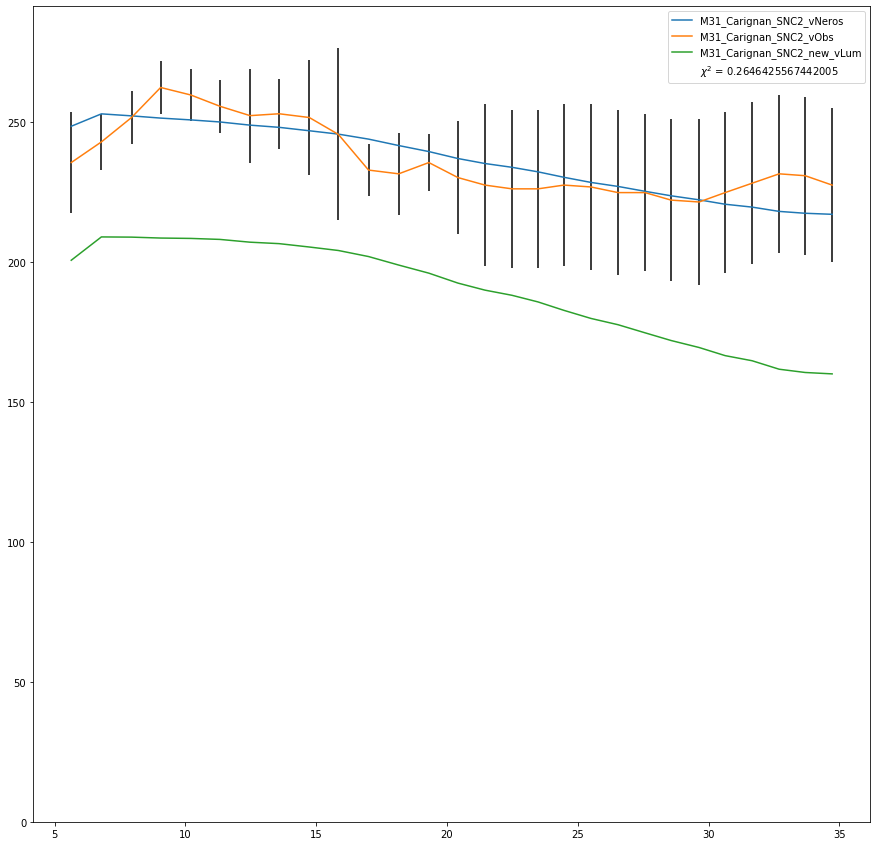

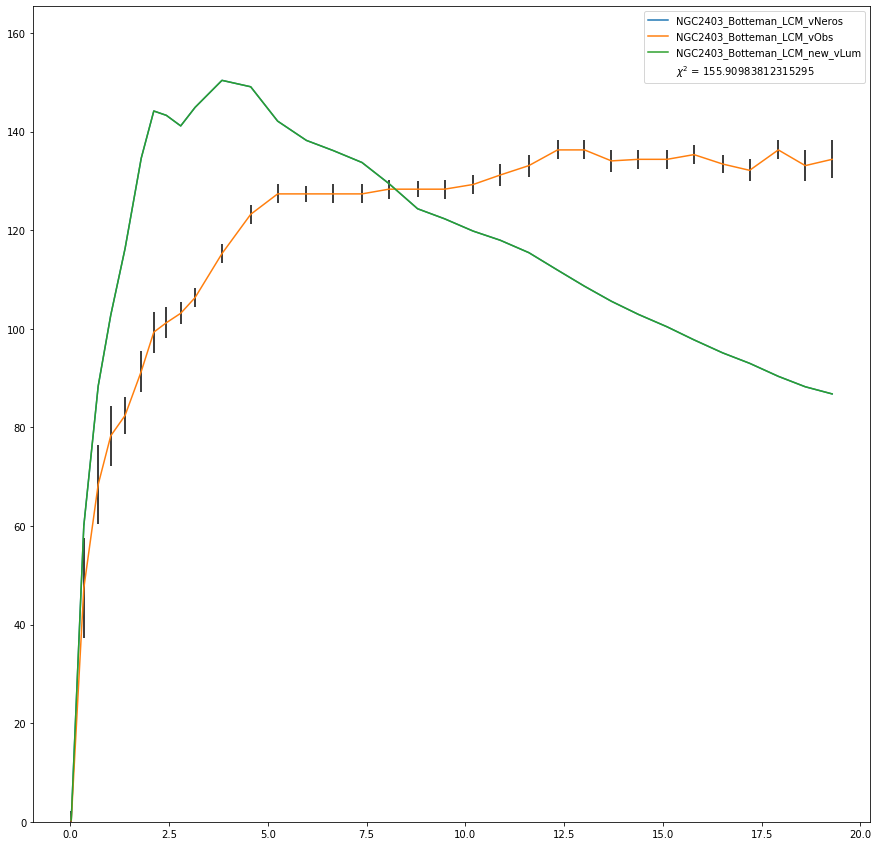

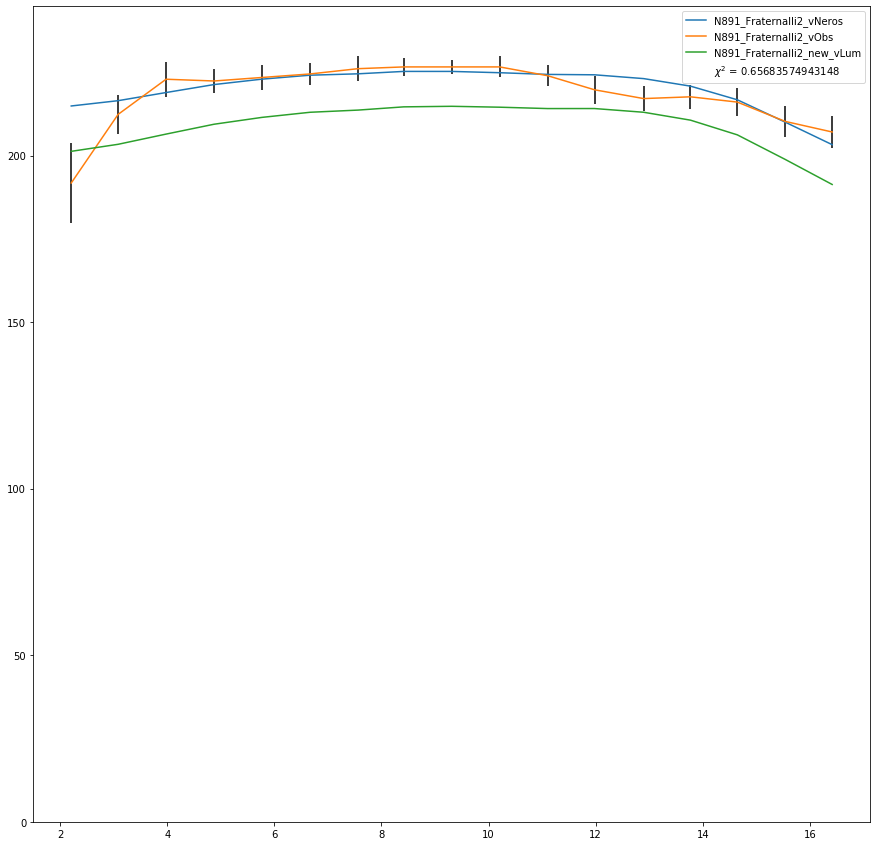

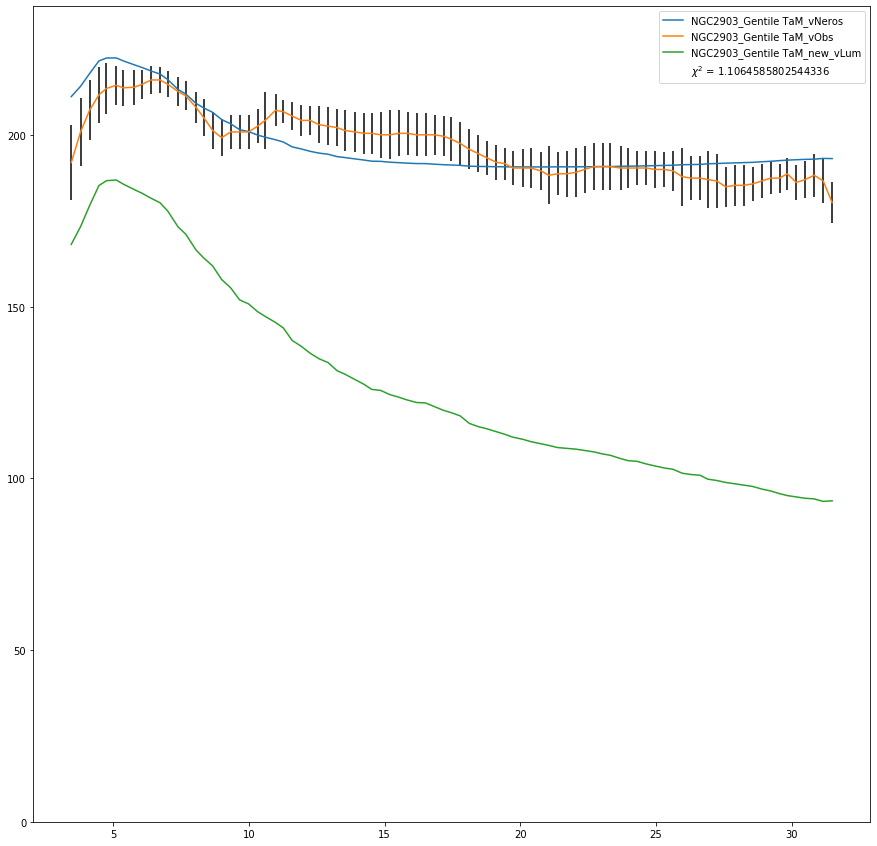

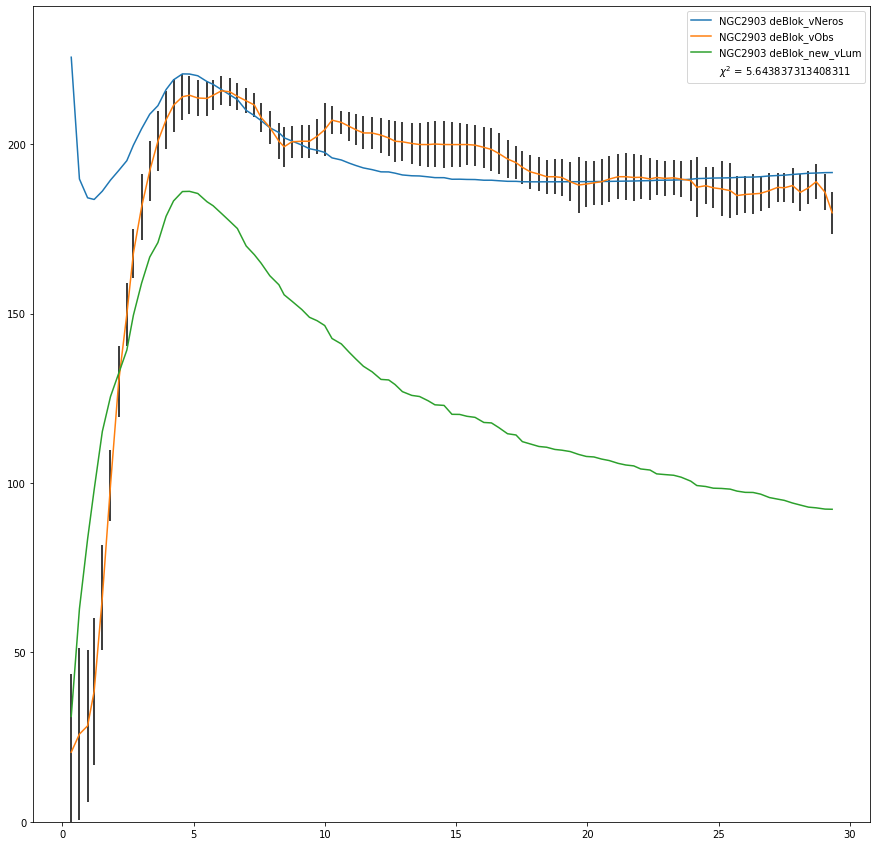

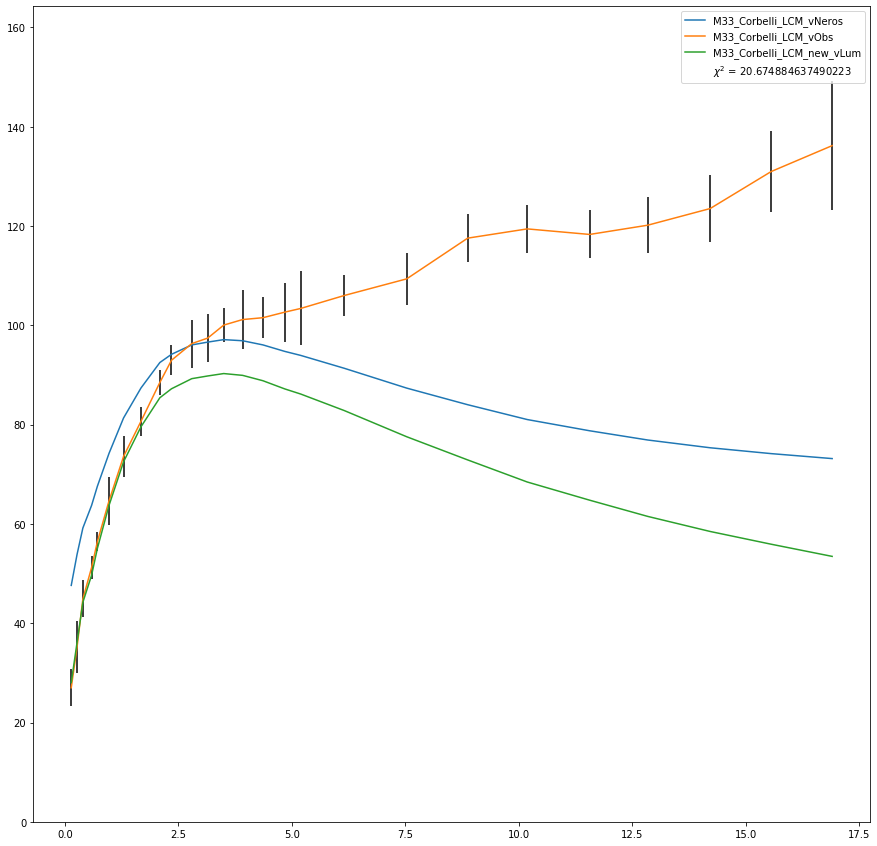

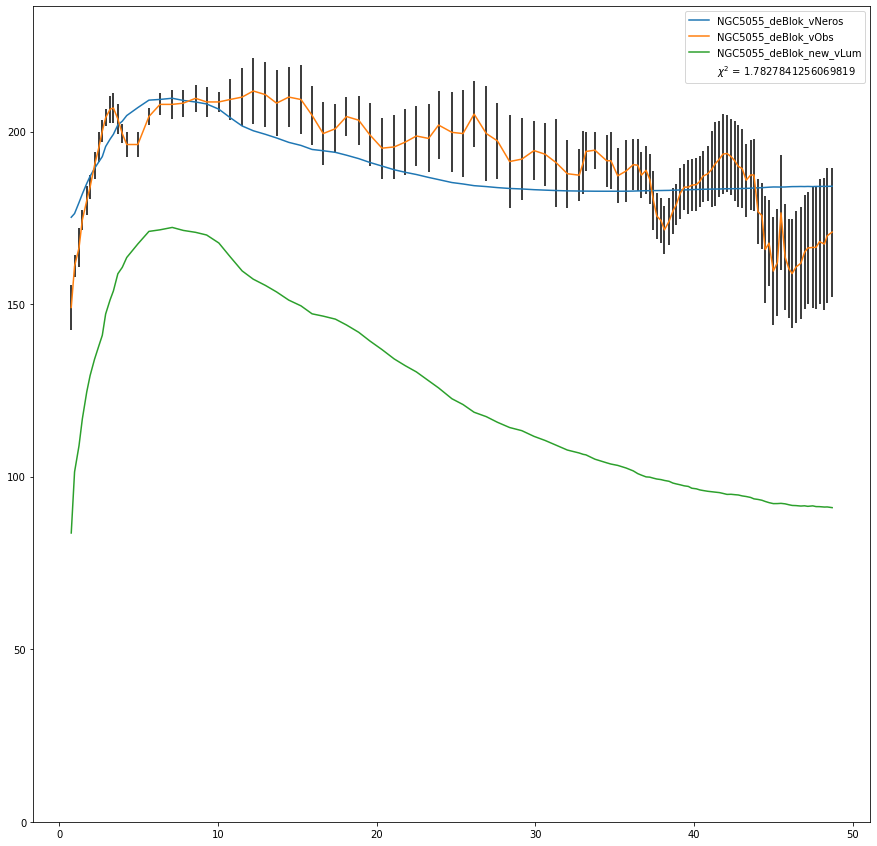

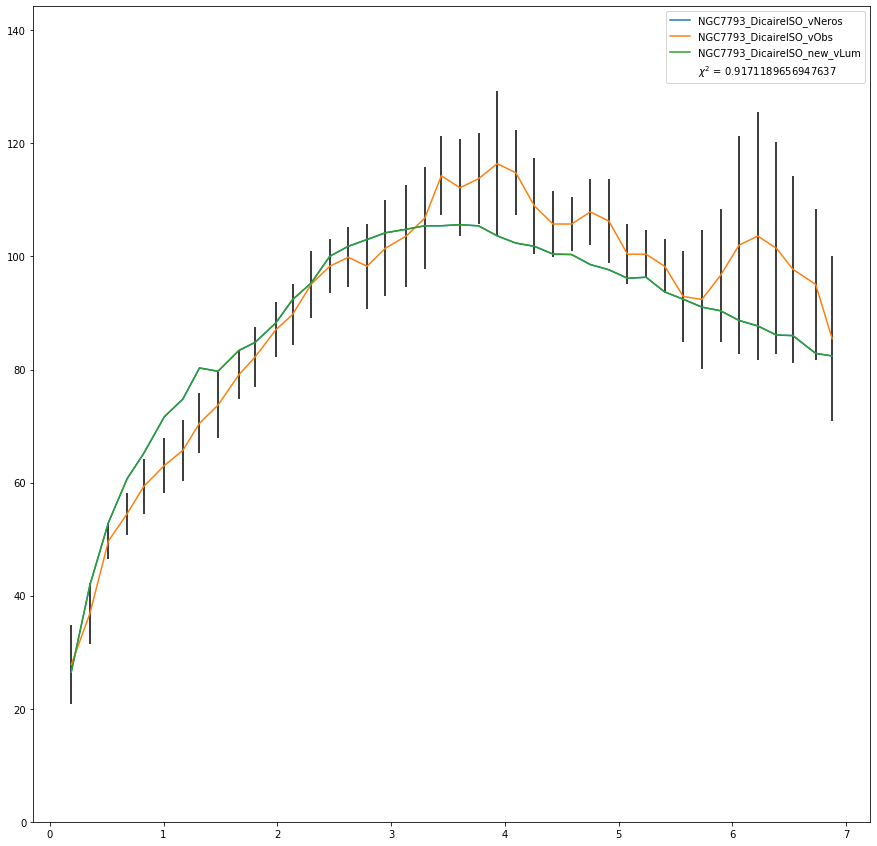

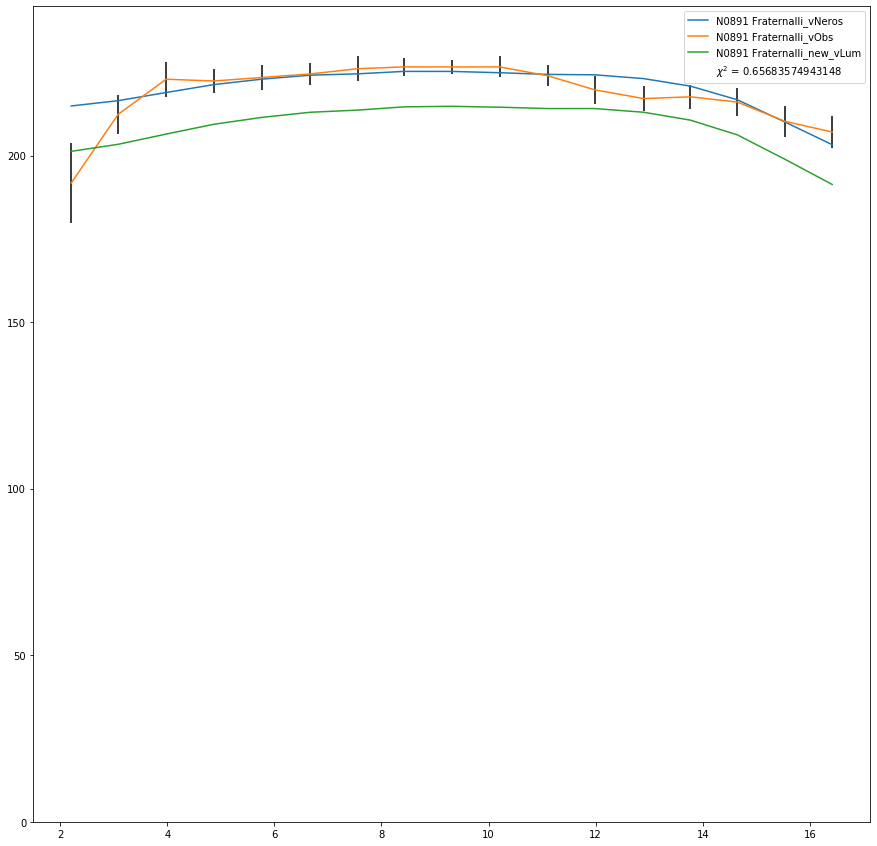

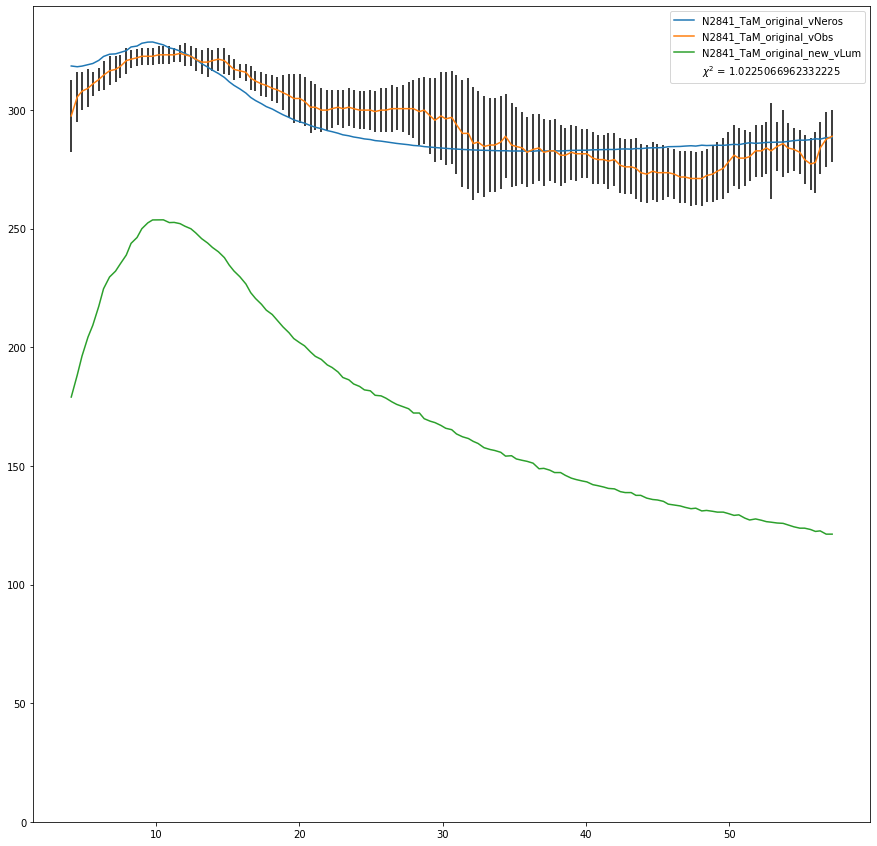

In [6]:
"""
This is the main body of the model. 
It loops through galaxies in the designated sample,
it calculates vLCM, vNeros, and chiSquared,
it fits galaxy data using alpha and vLumFreeParam,
it prints the values of alpha and vLumFreeParam to the console,
and it saves the graphs to a file.
"""

# This is where the fitted alpha & vlum free parameter will be written for each galaxy
out_file = "imported-data/data_" + str(MW_name) + ".csv"
with open(out_file, 'w') as f:
    f.write('{0},{1},{2},{3},{4},{5}\n'.format("Galaxy", "chi_square",  "alpha", "disk_scale", "bulge_scale","phi_zero"))
f.close()

total_chi_squared = []


for galaxyName in galaxies:
    f, ax = plt.subplots(1, figsize = (15, 15))
    
    # Extract out the needed galaxy components
    galaxy = np.array(galaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]

    # Just fit then extract the relevant pieces
    neros_fns.fit(galaxy_rad, galaxy_gas, galaxy_disk, galaxy_bulge, galaxy_vObs, galaxy_error)

    print(f"galaxyName is: {galaxyName}")
    fit_results = neros_fns.get_fit_results()
    for param in fit_results:
        print(f"{param} is: {fit_results[param]}")
    print("--------------------------")
    
    total_chi_squared.append(fit_results['chi_squared'])
    
    print("Running average chi_squared: {}".format(sum(total_chi_squared)/len(total_chi_squared)))

    
    # Write galaxyName, fitted parameters
    with open(out_file, 'a') as f:
        f.write(f"{galaxyName},{fit_results['chi_squared']},{fit_results['alpha']},{fit_results['disk_scale']},{fit_results['bulge_scale']},{MW_phi[-1]} \n")
    f.close()

    trimmed_rad = neros_fns.get_rad()
    trimmed_vLum_updated = neros_fns.get_vLum_scaled()
    trimmed_vObs = neros_fns.get_vObs()
    trimmed_error = neros_fns.get_vObsError()
    vNeros = neros_fns.get_vNeros()
    
    # plot
    # y-axis scales to the maximum velocity value in the list galaxy_vObs_err_incl
    # or to the maximum value in the list vNeros, whichever is the bigger number
    y_max = max(max(trimmed_vObs + trimmed_error), max(vNeros))
    ax.set_ylim(bottom = 0, top = y_max + 15)

    # plot vObs and vNeros and updated vLum
    ax.plot(trimmed_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(trimmed_rad, trimmed_vObs, label="{}_vObs".format(galaxyName))
    ax.plot(trimmed_rad, trimmed_vLum_updated, label="{}_new_vLum".format(galaxyName))
    ax.plot([],[], ' ', label="$\chi^2$ = {}".format(fit_results['chi_squared']))

    # error bar in vObs
    for i in range(len(trimmed_rad)):
        ax.vlines(trimmed_rad[i], trimmed_vObs[i] - trimmed_error[i], trimmed_vObs[i] + trimmed_error[i])

    ax.legend(loc="upper right")

    graph_file_name = "graphs/" + str(galaxyName) + "_" + str(MW_name)

    plt.savefig(graph_file_name)
